In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
cd/content/drive/MyDrive/PRO

/content/drive/MyDrive/PRO


In [ ]:
!unzip data.zip

Archive:  data.zip
  inflating: data/dev.csv            
  inflating: data/test.csv           
  inflating: data/train.csv          


In [3]:
# Nhập các thư viện
import re
import pickle
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from tensorflow.keras import optimizers
from keras.layers import Input, Dense, Embedding, Bidirectional, GRU, LSTM, Dropout, GlobalMaxPooling1D, SpatialDropout1D
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
from keras.models import Model, load_model
from keras.preprocessing import text, sequence
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from keras import backend as K


In [4]:
# Đọc file data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
dev_df = pd.read_csv('data/dev.csv')

In [5]:
X_train = train_df['free_text']
y_train = train_df['label_id'].values

X_dev = dev_df['free_text']
y_dev = dev_df['label_id'].values

X_test = test_df['free_text']
y_test = test_df['label_id'].values

In [6]:
!pip install pyvi
from pyvi.ViTokenizer import ViTokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.5 MB 26.6 MB/s 
     |████████████████████████████████| 965 kB 65.5 MB/s 


In [ ]:
# Tải vietnamese-stopwords
!wget https://github.com/stopwords/vietnamese-stopwords/blob/master/vietnamese-stopwords.txt

--2022-10-01 12:11:00--  https://github.com/stopwords/vietnamese-stopwords/blob/master/vietnamese-stopwords.txt
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘vietnamese-stopwords.txt’

vietnamese-stopword     [ <=>                ] 600.13K  --.-KB/s    in 0.04s   

2022-10-01 12:11:00 (15.3 MB/s) - ‘vietnamese-stopwords.txt’ saved [614538]



In [7]:
# Xây dựng hàm tiền xử lý dữ liệu
with open('vietnamese-stopwords.txt', "r") as f:
    stopwords = []
    for line in f:
        d = line.strip('\n')
        stopwords.append(d)
    stopwords = set(stopwords)

def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)
        
    return train_sentences

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def preprocess(text, tokenized = True, lowercased = True):
    text = ViTokenizer.tokenize(text) if tokenized else text
    text = filter_stop_words(text, stopwords)
    text = deEmojify(text)
    text = text.lower() if lowercased else text
    return text

# --------------TRICH XUAT DAC TRUNG -------------------------
def pre_process_features(X, y, tokenized = True, lowercased = True):
    X = [preprocess(str(p), tokenized = tokenized, lowercased = lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y, idx)
    return X, y

In [16]:
!pip install -q kaggle

In [17]:
from google.colab import files

In [18]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tnhnguynquang","key":"0cfd796c162ea6dd3bacafbc92ce4d1d"}'}

In [19]:
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [20]:
# Tải vietnamese-word-vectors
!kaggle datasets download -d aeryss/fasttext-vietnamese-word-vectors-full

100% 5.37G/5.37G [01:46<00:00, 69.8MB/s]
100% 5.37G/5.37G [01:46<00:00, 54.3MB/s]


In [21]:
!unzip fasttext-vietnamese-word-vectors-full.zip

Archive:  fasttext-vietnamese-word-vectors-full.zip
  inflating: cc.vi.300.bin           
  inflating: cc.vi.300.vec           


In [8]:
vocabulary_size = 10000
sequence_length = 100
embedding_dim = 300

In [9]:
# Xử lý dữ liệu
train_X, train_y = pre_process_features(X_train, y_train, tokenized=True, lowercased = True)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=True, lowercased = True)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True, lowercased = True)

In [10]:
# Lấy word index
tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(train_X)
word_index = tokenizer.word_index

In [12]:
def make_featues(X, y, tokenizer, is_one_hot_label=True):
    X = tokenizer.texts_to_sequences(X)
    X = sequence.pad_sequences(X, maxlen=sequence_length)
    if is_one_hot_label: 
        y = to_categorical(y, num_classes=3)

    return X, y

In [13]:
# Make features
train_X, train_y = make_featues(train_X, train_y, tokenizer)
dev_X, dev_y = make_featues(dev_X, dev_y, tokenizer)
test_X, test_y = make_featues(test_X, test_y, tokenizer, is_one_hot_label=False)

In [22]:
# Tạo embedding matrix
embeddings_index = {}
with open('cc.vi.300.vec', encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

num_words = min(vocabulary_size, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [24]:
# GRU
input = Input(shape=(sequence_length,))
x = Embedding(num_words, embedding_dim, weights=[embedding_matrix])(input)
x = Bidirectional(GRU(128, return_sequences=True))(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.1)(x)
output = Dense(3, activation="softmax")(x)
# creates a model
model = Model(inputs=input, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          5954100   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 256)         330240    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 64)                8256  

In [25]:
# Optimize và compile model
def optimize(model):

    model.compile(optimizer=optimizers.Adam(learning_rate=1e-2),
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    return model

model = optimize(model)

In [29]:
# Tạo callback model
def callback_model(checkpoint_name, logs_name):
    
    #1 Tạo tensorboard callback để lưu logs
    tensorboard_callback = TensorBoard(logs_name, histogram_freq=1)
    #2 Tạo checkpoint callback để lưu checkpoint với độ chính xác tốt nhất sau mỗi epoch.
    checkpoint_callback = ModelCheckpoint(filepath=checkpoint_name,
                                          save_freq='epoch',
                                          monitor='acc',
                                          save_best_only=True,
                                          verbose=1)
    #3 Tạo ReduceLROnPlateau callback với factor=0.3, patience=1 và "Validation F1-score" monitor.
    ReduceLROnPlateau_callback = ReduceLROnPlateau(monitor="acc", factor=0.3, patience=1, verbose=1)
    #4 Tạo early stopping callback với patience=5, mode = 'max' và "Validation F1-score" monitor.
    early_stop_callback = EarlyStopping(monitor="acc", patience=5, mode="max", verbose=1)
    # 5 Tổng hợp callback list
    callbacks_list = [tensorboard_callback, checkpoint_callback, ReduceLROnPlateau_callback, early_stop_callback]
    return callbacks_list

checkpoint_name = 'weights.best.hdf5'
logs_name = 'training_logs'
callbacks_list = callback_model(checkpoint_name, logs_name)

In [30]:
# Hàm train model
def train_model(model, callbacks_list):
    '''
    Input: 
        Mô hình và callback list,
    Return: 
        Mô hình với trọng số checkpoint tốt nhất.
    '''
    model.fit(train_X, train_y,
              validation_data=(dev_X, dev_y),
              epochs=30, batch_size=256,
              verbose=1,
              callbacks=callbacks_list)
    model = load_model(filepath = checkpoint_name)
    return model

model = train_model(model, callbacks_list)

Epoch 1/30
93/94 [============================>.] - ETA: 0s - loss: 0.0353 - acc: 0.9870
Epoch 1: acc improved from -inf to 0.98707, saving model to weights.best.hdf5
94/94 [==============================] - 8s 66ms/step - loss: 0.0351 - acc: 0.9871 - val_loss: 0.7567 - val_acc: 0.8612 - lr: 8.1000e-05
Epoch 2/30
93/94 [============================>.] - ETA: 0s - loss: 0.0343 - acc: 0.9875
Epoch 2: acc improved from 0.98707 to 0.98757, saving model to weights.best.hdf5
94/94 [==============================] - 5s 53ms/step - loss: 0.0341 - acc: 0.9876 - val_loss: 0.7734 - val_acc: 0.8608 - lr: 8.1000e-05
Epoch 3/30
94/94 [==============================] - ETA: 0s - loss: 0.0328 - acc: 0.9878
Epoch 3: acc improved from 0.98757 to 0.98782, saving model to weights.best.hdf5
94/94 [==============================] - 5s 53ms/step - loss: 0.0328 - acc: 0.9878 - val_loss: 0.7866 - val_acc: 0.8604 - lr: 8.1000e-05
Epoch 4/30
93/94 [============================>.] - ETA: 0s - loss: 0.0322 - acc: 

[[5239  131  178]
 [ 212  157   75]
 [ 284   70  334]]
F1 - micro: 0.8577844311377246
F1 - macro: 0.6146988308268765
Accuracy: 0.8577844311377245


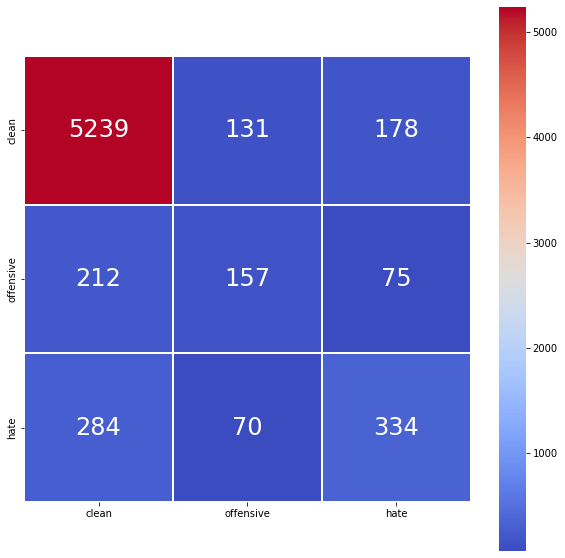

In [31]:
# Đưa ra dự đoán
prediction = model.predict(test_X, batch_size=256, verbose=0)
y_pred = prediction.argmax(axis=-1)

# Confusion matrix
cf = confusion_matrix(test_y, y_pred)
print(cf)

# Tính F1-micro
eval_micro = f1_score(test_y, y_pred, average='micro')
print("F1 - micro: " + str(eval_micro))

#Tính F1-macro
eval_macro = f1_score(test_y, y_pred, average='macro')
print("F1 - macro: " + str(eval_macro))

#Tính accuracy_score
acc_sc = accuracy_score(test_y, y_pred)
print("Accuracy: " + str(acc_sc))

# Hiển thị Confusion matrix
df_cm = pd.DataFrame(cf, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.subplots(figsize=(10, 10))
sn.heatmap(df_cm, annot=True, cmap="coolwarm",fmt='d', linewidths = 1, cbar=True, square = True, annot_kws={"size": 24})

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 13.0 MB/s 
     |████████████████████████████████| 163 kB 53.6 MB/s 
     |████████████████████████████████| 6.6 MB 44.2 MB/s 


In [ ]:
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer

In [ ]:
train_X, train_y = pre_process_features(X_train, y_train)
dev_X, dev_y = pre_process_features(X_dev, y_dev)
test_X, test_y = pre_process_features(X_test, y_test)

# Tạo model pre_train  
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels = 3)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base",use_fast=False)

import torch

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=100)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=100)
test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=100)

train_dataset = BuildDataset(train_encodings, train_y)
dev_dataset = BuildDataset(dev_encodings, dev_y)
test_dataset = BuildDataset(test_encodings, test_y)


Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['

Downloading:   0%|          | 0.00/895k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 24048
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2256


Step,Training Loss
500,0.440800
1000,0.330900
1500,0.276900
2000,0.194000


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/PRO/phobert-v1/checkpoint-500
Configuration saved in /content/drive/MyDrive/Colab Notebooks/PRO/phobert-v1/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/PRO/phobert-v1/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/PRO/phobert-v1/checkpoint-1000
Configuration saved in /content/drive/MyDrive/Colab Notebooks/PRO/phobert-v1/checkpoint-1000/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/PRO/phobert-v1/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/PRO/phobert-v1/checkpoint-1500
Configuration saved in /content/drive/MyDrive/Colab Notebooks/PRO/phobert-v1/checkpoint-1500/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/PRO/phobert-v1/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to /content/drive/MyDrive/Colab Notebook

[[5291  121  136]
 [ 187  185   72]
 [ 208   75  405]]
F1 - micro: 0.8803892215568864
F1 - macro: 0.6710149171309888


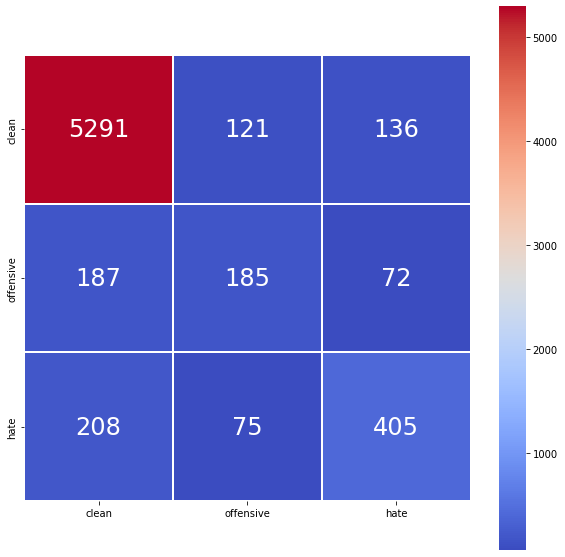

In [ ]:
# TrainingArguments
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Colab Notebooks/PRO/phobert-v1/',          
    num_train_epochs=3,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=32,   
    do_eval=True
)

# Trainer
trainer = transformers.Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)

trainer.train()

# Lưu model 
trainer.save_model("/content/drive/MyDrive/Colab Notebooks/PRO/phobert-v1/")

# Đưa ra dự đoán
y_pred_classify = trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
y_true = test_y

# Confusion matrix
cf1 = confusion_matrix(y_true, y_pred)
print(cf1)

#Tính F1-micro
eval_micro = f1_score(y_true, y_pred, average='micro')
print("F1 - micro: " + str(eval_micro))

# Tính F1-macro
eval_macro = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(eval_macro))

# Hiển thị Confusion matrix
df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.subplots(figsize=(10, 10))
sn.heatmap(df_cm1, annot=True, cmap="coolwarm",fmt='d', linewidths = 1, cbar=True, square = True, annot_kws={"size": 24})